Solving Burgers

$\frac{\partial f}{\partial t} + f\frac{\partial f}{\partial x} - \mu\frac{\partial^2 f}{\partial x^2}$=0

This Notebook solves above equation using a minimalistic PINNs approach following the example A1 in appendix of 
[Raissi et. al, Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations](https://doi.org/10.1016/j.jcp.2018.10.045)

In [8]:
#Importing  np, and tf libs

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from time import time

In [9]:
############# PINN for Burgers ######################

In [10]:
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)  # Setting the default data types for the neural nets
pi = tf.constant(np.pi,dtype=DTYPE) # Value of Pie

In [11]:
# Initial conditions f(x,t=t_ini)
def initial_func(x):
    f = -tf.sin(x*pi)
    return f


# An auxilliary class just for generating random points 
class domain():
    def __init__(self,lower,upper,DTYPE):
        self.lwb = tf.constant(lower,dtype=DTYPE)
        self.upb = tf.constant(upper,dtype=DTYPE)
        self.dim = tf.constant(len(lower))
        
    def sample_domain(self,n=10):
        x = []
        for i in range(self.dim):
            print(self.lwb[i],self.upb[i])
            x.append(tf.random.uniform((n,1),self.lwb[i],self.upb[i],dtype=DTYPE))
            
        return tf.squeeze(tf.stack(x,axis=1))

    
# Function to generate initial data(uniformly sampling points for initial conditions)
def get_initial_data(dom,initial_func,n=50,t_ini=0.0):
    t = t_ini*tf.ones((n,1),dtype=DTYPE)
    
    x= [t]
    
    for i in range(1,dom.dim):
        x.append(tf.random.uniform((n,1),dom.lwb[i],dom.upb[i],dtype=DTYPE))
        
    
    
    
    dom_ini = tf.squeeze(tf.stack(x,axis=1))
    f_ini = initial_func(dom_ini[:,1:])
    
    return dom_ini ,f_ini

# Function to generate data for boundary conditions (i.e. f(x=-1,t) = f(x=1,t)=0)

def get_bndry_data(dom,n=50):
    
    t = tf.random.uniform((n,1), dom.lwb[0], dom.upb[0], dtype=DTYPE)
    x = dom.lwb[1] + (dom.upb[1] - dom.lwb[1]) * tf.keras.backend.random_bernoulli((n,1), 0.5, dtype=DTYPE)
    
    f_b = tf.zeros_like(x)
    
    return tf.squeeze(tf.stack((t,x),axis=1)),f_b
    
    
# Function generating training points for differential equation(PINNs) loss training using Latin hypercube sampling
def get_domain_points_lhs(x_min=-1.0,x_max=1.0,t_min=0.0,t_max=1.0,n=100):
    
    from scipy.stats import qmc
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n)
    l_bounds = [t_min,x_min]
    u_bounds = [t_max,x_max]
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
    t = 1.0*sample_scaled[:,0]
    x = 1.0*sample_scaled[:,1]
    
    
    t = tf.constant(t,dtype=DTYPE)
    x = tf.constant(x,dtype=DTYPE)
    
    return tf.stack((t,x),axis=1)

In [12]:
lower = (0.0,-1.0)
upper = (1.0,1.0)
dom = domain(lower,upper,DTYPE=DTYPE)


# Generating training data and data points


x_i,f_i = get_initial_data(dom,initial_func,n=100)
x_b,f_b = get_bndry_data(dom,50)

print(x_i.shape,x_i.shape,f_i.shape,f_b.shape)

x_bndry = tf.concat((x_i,x_b),axis=0)  # Boundary points(including initial data points)
f_bndry = tf.concat((f_i,f_b),axis=0)  # Function values at boundary points

x_dom = get_domain_points_lhs(n=10000) #  Sample domain points for PINN loss training

#x_dom = tf.stack((t,x),axis=1)
#x_dom = dom.sample_domain(4000)
vis = tf.constant(0.01/np.pi,dtype=DTYPE)

print("data shape for supervise train",x_bndry.shape,f_bndry.shape,"data shape for PINN train",x_dom.shape)

(100, 2) (100, 2) (100, 1) (50, 1)
data shape for supervise train (150, 2) (150, 1) data shape for PINN train (10000, 2)


In [13]:
#This function is the core PINN function. It takes the neural net model, training points and problem constants and \
# returns the PINN(differential equations) loss.

def Burgers(model,x_dom,vis):
    t,x = x_dom[:,0:1],x_dom[:,1:2]
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)
        
        f = model(tf.stack((t[:,0],x[:,0]),axis=1))
        
        dx_f = tape.gradient(f,x)
        
    dt_f = tape.gradient(f,t)
    dxx_f = tape.gradient(dx_f,x)
    
    del tape
    
    return dt_f + f*dx_f - vis*dxx_f  


#This just gives the neural net with required no. of layers and neurons
def get_model(dom,no_hid_layers,no_of_neu=20,act='tanh'):
    
    n_inp = dom.dim.numpy
    lb = dom.lwb
    ub = dom.upb
    
    model = keras.Sequential()
    model.add(keras.Input(2))
    
    scale_layer = keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scale_layer)
    
    for i in range(no_hid_layers):
        model.add(keras.layers.Dense(no_of_neu,activation=tf.keras.activations.get('tanh'),kernel_initializer='glorot_normal'))
        
    model.add(keras.layers.Dense(1))
    
    return model

# The function to compute the net loss
def compute_loss(model,x_dom,x_bndry,f_bndry,vis):
    
    diff = Burgers(model,x_dom,vis) #Data point-wise values of diff. equations
    diff_loss = tf.reduce_mean(tf.square(diff)) #This the does sqr. summation over all data points
    
    f_pred = model(x_bndry) #Apply neural net on boundary points to get prediction on boundary points(initial+boundary)
    bndry_loss = tf.reduce_mean(tf.square(f_pred-f_bndry)) # Calculate loss function
    
    return diff_loss+bndry_loss


# This function gets gradients along with loss
def get_grads(model,x_dom,x_bndry,f_bndry,vis):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        
        loss = compute_loss(model,x_dom,x_bndry,f_bndry,vis)
        
    grds = tape.gradient(loss,model.trainable_variables)
    del tape
    return loss,grds

In [14]:
# Get model(Neural net with 8 hidden layers)
model = get_model(dom,8)
model.summary()  # Print Neural net summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                4

In [15]:
# Setting the learning rate for Adam optimizer
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)


# This is the a single training step which is looped over during training 
@tf.function
def train_step():
    loss,grds = get_grads(model,x_dom,x_bndry,f_bndry,vis)
    optim.apply_gradients(zip(grds, model.trainable_variables))
    
    return loss

n_epochs = 5000 # Totla no. of training epochs
hist = []
t0 = time()
for i in range(n_epochs):
    loss = train_step()
    
    if i%50==0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
        
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.20832729e-01
It 00050: loss = 1.29491821e-01
It 00100: loss = 8.37033689e-02
It 00150: loss = 7.27101415e-02
It 00200: loss = 6.37183115e-02
It 00250: loss = 6.46492019e-02
It 00300: loss = 5.45506626e-02
It 00350: loss = 6.34706989e-02
It 00400: loss = 1.80882499e-01
It 00450: loss = 5.71094081e-02
It 00500: loss = 2.79337049e-01
It 00550: loss = 7.62819052e-02
It 00600: loss = 5.80585450e-02
It 00650: loss = 3.48981246e-02
It 00700: loss = 7.09374025e-02
It 00750: loss = 3.45201343e-02
It 00800: loss = 1.21104650e-01
It 00850: loss = 3.77992503e-02
It 00900: loss = 1.38798663e-02
It 00950: loss = 1.59701966e-02
It 01000: loss = 1.43746957e-02
It 01050: loss = 7.45591056e-03
It 01100: loss = 6.52970467e-03
It 01150: loss = 5.76136261e-03
It 01200: loss = 5.19821793e-03
It 01250: loss = 4.74677607e-03
It 01300: loss = 4.36767377e-03
It 01350: loss = 4.04179469e-03
It 01400: loss = 3.75761651e-03
It 01450: loss = 3.50679085e-03
It 01500: loss = 3.28310393e-03
It 01550

In [16]:
# Plot the predicted solutions

32/32 [==============================] - 0s 325us/step


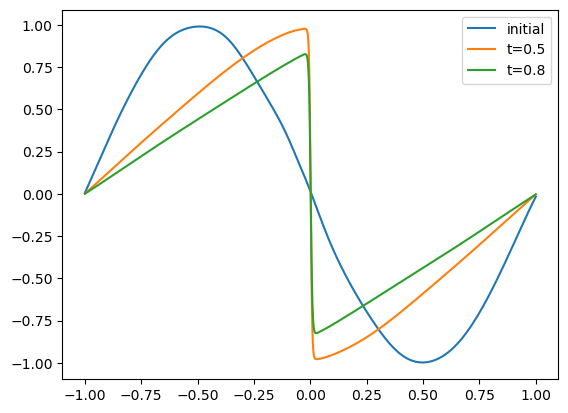

In [17]:
xi = tf.linspace(-1.0,1.0,1000)
tt = 0.0*tf.ones_like(xi)
d = tf.stack((tt,xi),axis=1)
prd = model.predict(d)

tt = 0.5*tf.ones_like(xi)
d = tf.stack((tt,xi),axis=1)
prd2 = model.predict(d)

tt = 0.8*tf.ones_like(xi)
d = tf.stack((tt,xi),axis=1)
prd3 = model.predict(d)

plt.plot(xi,prd,label="initial")
plt.plot(xi,prd2,label="t=0.5")
plt.plot(xi,prd3,label="t=0.8")
plt.legend(loc='best')

In [1]:
# Above fragments can be put together in a class as in following code

In [2]:
############    Initial Class Implements ###########

In [ ]:
class PINN():
    def __init__(self,dom_bounds,prob_coef,DTYPE='float32'):
        self.DTYPE = DTYPE
        self.lwb = tf.constant(dom_bounds[0],dtype=DTYPE)
        self.upb = tf.constant(dom_bounds[1],dtype=DTYPE)
        self.dim = tf.constant(len(dom_bounds[0]))
        
        
            
        self.prob_coef = tf.constant(prob_coef,dtype=DTYPE)
        
        print("Prob coef",self.prob_coef[0])
        print("Bounds",self.lwb,self.upb)
        
        
        self.model: keras.Model

    def pt(self):
        print(self.model.summary())

        
        
        
    def sample_domain(self,n=10):
        x = []
        for i in range(self.dim):
            print(self.lwb[i],self.upb[i])
            x.append(tf.random.uniform((n,1),self.lwb[i],self.upb[i],dtype=self.DTYPE))
            
        return tf.squeeze(tf.stack(x,axis=1))
    
    
    def make_model(self,no_hid_layers,no_of_neu=20,act='tanh'):
    
        n_inp = tf.constant(self.dim)
        lb = self.lwb
        ub = self.upb
    
        scale_layer = keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        
        inp = keras.Input(shape=(n_inp,))
        x = scale_layer(inp)
       
      
    
        for i in range(no_hid_layers):
            x = keras.layers.Dense(no_of_neu,activation=tf.keras.activations.get(act),kernel_initializer='glorot_normal')(x)
        
        out = keras.layers.Dense(1)(x)
    
        return keras.Model(inp,out)
    
    
    def diff_eqn(self,dom_points):
        t,x = dom_points[:,0:1],dom_points[:,1:2]
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)
            tape.watch(x)
        
            f = self.model(tf.stack((t[:,0],x[:,0]),axis=1))
        
            dx_f = tape.gradient(f,x)
        
        dt_f = tape.gradient(f,t)
        dxx_f = tape.gradient(dx_f,x)
    
        del tape
    
        return dt_f + f*dx_f - self.prob_coef[0]*dxx_f  
    
    def compute_loss(self,dom_points,bndry_points,f_bndry):
        
        diff = self.diff_eqn(dom_points)
        diff_loss = tf.reduce_mean(tf.square(diff))
    
        f_pred = self.model(x_bndry)
        bndry_loss = tf.reduce_mean(tf.square(f_pred-f_bndry))
    
        return diff_loss+bndry_loss
    
    def get_grads(self,dom_points,bndry_points,f_bndry):
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
        
            loss = self.compute_loss(dom_points,bndry_points,f_bndry)
        
        grds = tape.gradient(loss,self.model.trainable_variables)
        del tape
        
        return loss,grds 
    
    def train_step(self,optim,dom_points,bndry_points,f_bndry):
        loss,grds = self.get_grads(dom_points,bndry_points,f_bndry)
        optim.apply_gradients(zip(grds, self.model.trainable_variables))
    
        return loss
    
    def train(self,optim,dom_points,bndry_points,f_bndry,n_epochs = 5000):
        
        losses = []
        t0 = time()
        for i in range(n_epochs):
            loss = self.train_step(optim,dom_points,bndry_points,f_bndry)
            losses.append(losses)
    
            if i%50==0:
                print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        return losses